In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import itertools
warnings.filterwarnings('ignore')

In [3]:
symbols_list = ['MSFT']
start_date = '2010-01-01'
end_date = '2025-07-07'
df = yf.download(tickers=symbols_list, start=start_date, end=end_date, interval='1d', auto_adjust=False)

#indicators
sma_seed_period = 15
period = 15
alpha = 2 / (period + 1)
prices = df['Adj Close', 'MSFT'].values

ema_values = []

# Step 1: Calculate the SMA seed for the first EMA value (at index 29)
for i in range(len(prices)):
    if i == sma_seed_period - 1:
        sma_seed = np.mean(prices[:sma_seed_period])
        ema_values.append(sma_seed)
    elif i >= sma_seed_period:
        current_price = prices[i]
        previous_ema = ema_values[-1]
        new_ema = (current_price * alpha) + (previous_ema * (1 - alpha))
        ema_values.append(new_ema)
    else:
        ema_values.append(np.nan)  # Not enough data for SMA/EMA yet


df['ema_manual'] = ema_values
df['sma'] = df['Adj Close', 'MSFT'].rolling(window=30).mean()
df['rsi'] = pandas_ta.rsi(df['Adj Close', 'MSFT'], length=30)
df['rsi_mid'] = df['rsi'].rolling(window=30).mean()

#Signals
df['sma_signal'] = np.where(df['ema_manual'] > df['sma'] , 1, 0)
df['rsi_above_mid'] = df['rsi'] > df['rsi_mid']
df['rsi_signal'] = np.where(df['rsi'] > df['rsi_mid'] , 1, 0)
df['rsi_50_signal'] = np.where(df['rsi_mid'] > 50, 1, 0)

df['returns'] = df['Adj Close', 'MSFT'].pct_change()
df['returns_acc'] = (1+df['returns'].fillna(0)).cumprod()

#Probability tree 
# Create a separate DataFrame for the probability tree (don't overwrite your main df)
# Binary values
values = [0, 1]

# All combinations for 3 binary indicators
paths = list(itertools.product(values, repeat=3))

# Create probability tree DataFrame with a different name
prob_tree = pd.DataFrame(paths, columns=['sma_signal', 'rsi_signal', 'rsi_50_signal'])

# Calculate actual probabilities from your historical data
# First, let's get the actual signal combinations from your main DataFrame

df['signal_combo'] = list(zip(df['rsi_signal'], df['rsi_50_signal'], df['sma_signal']))
combo_counts = df['signal_combo'].value_counts()
total_observations = len(df)








df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,ema_manual,sma,rsi,rsi_mid,sma_signal,rsi_above_mid,rsi_signal,rsi_50_signal,returns,returns_acc,signal_combo
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2010-01-04,23.211443,30.950001,31.100000,30.590000,30.620001,38409100,NaN,NaN,NaN,NaN,0,False,0,0,NaN,1.000000,"(0, 0, 0)"
2010-01-05,23.218935,30.959999,31.100000,30.639999,30.850000,49749600,NaN,NaN,NaN,NaN,0,False,0,0,0.000323,1.000323,"(0, 0, 0)"
2010-01-06,23.076447,30.770000,31.080000,30.520000,30.879999,58182400,NaN,NaN,NaN,NaN,0,False,0,0,-0.006137,0.994184,"(0, 0, 0)"
2010-01-07,22.836452,30.450001,30.700001,30.190001,30.629999,50559700,NaN,NaN,NaN,NaN,0,False,0,0,-0.010400,0.983845,"(0, 0, 0)"
2010-01-08,22.993954,30.660000,30.879999,30.240000,30.280001,51197400,NaN,NaN,NaN,NaN,0,False,0,0,0.006897,0.990630,"(0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,495.940002,495.940002,499.299988,493.029999,497.549988,34539200,481.803974,469.757331,69.668807,65.699938,1,True,1,1,-0.003036,21.366186,"(1, 1, 1)"
2025-06-30,497.410004,497.410004,500.760010,495.329987,497.040009,28369000,483.754728,471.233331,70.033578,65.885823,1,True,1,1,0.002964,21.429517,"(1, 1, 1)"


In [4]:
def analyze_signal_combination(df, combo_tuple, combo_name):
    """
    Analyze trading performance for a specific signal combination
    Signal order: (rsi_signal, rsi_50_signal, sma_signal)
    """
    # Create indicator column for this combination
    if combo_name.endswith('_ONLY'):
        if 'RSI_50' in combo_name:
            df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x[1] == 1 else 0) #RSI50 (0, 1, 0)
        elif 'RSI' in combo_name and 'RSI_50' not in combo_name:
            df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x[0] == 1 else 0) #RSI (1, 0, 0)
        elif 'SMA' in combo_name:
            df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x[2] == 1 else 0) #SMA (0, 0, 1)
    elif combo_name == "RSI_RSI50_COMBO":
        # RSI + RSI_50 combinations: any combination where both RSI and RSI_50 are active
        df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x[0] == 1 and x[1] == 1 else 0)
    elif combo_name == "RSI_SMA_COMBO":
        # RSI + SMA combinations: any combination where both RSI and SMA are active
        df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x[0] == 1 and x[2] == 1 else 0)
    elif combo_name == "RSI50_SMA_COMBO":
        # RSI_50 + SMA combinations: any combination where both RSI_50 and SMA are active
        df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x[1] == 1 and x[2] == 1 else 0)
    else:
        # For exact combinations, use exact match
        df[f'ind_{combo_name}'] = df['signal_combo'].apply(lambda x: 1 if x == combo_tuple else 0)

    df[f'signal_diff_{combo_name}'] = df[f'ind_{combo_name}'].diff().shift(1).fillna(0)

    # Create shifted signal diff (step 2 removed - no clearing of original -1s)
    df[f'signal_diff_shifted_{combo_name}'] = df[f'signal_diff_{combo_name}'].copy()
    df.loc[df[f'signal_diff_{combo_name}'] == -1, f'signal_diff_shifted_{combo_name}'] = 0
    shifted_signals = (df[f'signal_diff_{combo_name}'] == -1).shift(1).fillna(False)
    df.loc[shifted_signals, f'signal_diff_shifted_{combo_name}'] = np.where(df.loc[shifted_signals, f'signal_diff_{combo_name}'] == 1, 0, -1)
    
    df[f'signal_period_{combo_name}'] = df[f'signal_diff_shifted_{combo_name}'].ne(0).cumsum()
    
    # Get trading price 
    df[f'trad_price_{combo_name}'] = np.where(df[f'signal_diff_{combo_name}'].isin([1, -1]), df[('Adj Close', 'MSFT')].shift(-1), np.nan)
    df[f'trad_price_{combo_name}'] = df[f'trad_price_{combo_name}'].fillna(method='ffill')
    df[f'trad_price_{combo_name}'] = df[f'trad_price_{combo_name}']

    #returns - only calculate when signal_diff is -1 (sell signal)
    df[f'returns_{combo_name}'] = np.where(
        df[f'signal_diff_{combo_name}'] == -1,
        df[f'trad_price_{combo_name}'].pct_change(),
        0
    )
    df[f'returns_{combo_name}'] = df[f'returns_{combo_name}'].replace([np.inf, -np.inf], 0)   
    df[f'ret_acc_{combo_name}'] = (1+df[f'returns_{combo_name}']).cumprod()

    # Analyze periods
    period_returns = []
    unique_periods = df[f'signal_period_{combo_name}'].unique()
    
    for period_id in unique_periods:
        if period_id == 0:
            continue
        period_data = df[df[f'signal_period_{combo_name}'] == period_id]
        price_col = period_data[('Adj Close', 'MSFT')]
        
        if len(period_data) > 1 and period_data[f'signal_diff_shifted_{combo_name}'].iloc[0] == 1:
            period_return = (price_col.iloc[-1] - price_col.iloc[0]) / price_col.iloc[0]
            sell_return = 0
        elif len(period_data) > 1 and period_data[f'signal_diff_shifted_{combo_name}'].iloc[0] == -1:
            sell_return = (price_col.iloc[-1] - price_col.iloc[0]) / price_col.iloc[0]
            period_return = 0
        else:
            period_return = 0
            sell_return = 0
            
        period_returns.append({
            'period_id': period_id,
            'start_date': period_data.index[0] if len(period_data) > 0 else None,
            'end_date': period_data.index[-1] if len(period_data) > 0 else None,
            'buy_return': period_return,
            'sell_return': sell_return
        })
    
    # Create DataFrame from period_returns
    period_df = pd.DataFrame(period_returns)
    if len(period_df) > 0:
        period_df['period_length'] = (period_df['end_date'] - period_df['start_date']).dt.days + 1
        return period_df
    else:
        return pd.DataFrame()
    

# Analyze all possible signal combinations
# Signal order: (rsi_signal, rsi_50_signal, sma_signal)
signal_combinations = [
    ((0, 0, 0), "NO_SIGNAL"),           # Exact match - no signals
    ((0, 0, 1), "SMA_ONLY"),           # Extract SMA signal only
    ((0, 1, 0), "RSI_50_ONLY"),        # Extract RSI_50 signal only  
    ((1, 0, 0), "RSI_ONLY"),           # Extract RSI signal only
    ((0, 1, 1), "SMA_RSI_50_COMBO"),   # Exact match - both must be active
    ((1, 0, 1), "SMA_WITH_RSI"),       # Exact match - both must be active
    ((1, 1, 0), "RSI_WITH_RSI_50"),    # Exact match - both must be active
    ((1, 1, 1), "RSI_RSI50_SMA_COMBO"), # All 3 main signals active
    ("CUSTOM", "RSI_RSI50_COMBO"),           # RSI + RSI_50 combinations
    ("CUSTOM", "RSI_SMA_COMBO"),             # RSI + SMA combinations
    ("CUSTOM", "RSI50_SMA_COMBO"),           # RSI_50 + SMA combinations
]
# Store results for comparison
all_results = {}

for combo, name in signal_combinations:
    try:
        result_df = analyze_signal_combination(df, combo, name)
        all_results[name] = result_df
    except Exception as e:
        print(f"Error analyzing {name}: {e}")

# Summary comparison
print(f"\n{'='*140}")
print("COMPARATIVE SUMMARY")
print(f"{'='*140}")
print(f"{'Combination':<20} | {'Total Trades':<12} | {'Win Rate':<10} | {'Avg Return':<12} | {'Total Return':<12} | {'Longest Trade':<13} | {'Shortest Trade':<14} | {'Avg Length':<10}")
print("-" * 140)

for name, result_df in all_results.items():
    if len(result_df) > 0:
        num_trades = (result_df['period_length'] > 1).sum()
        num_positive = (result_df['buy_return'] > 0).sum()
        num_negative = (result_df['sell_return'] < 0).sum()

        win_rate = (num_positive + num_negative)  / num_trades if num_trades > 0 else 0
        avg_return = result_df[result_df['buy_return'] > 0]['buy_return'].mean() if num_positive > 0 else 0
        total_return = (1 + result_df['buy_return']).prod() - 1

        # Calculate additional statistics for all periods excluding one-day trades
        # Filter out one-day trades (period_length = 1) for length statistics
        multi_day_trades = result_df[result_df['period_length'] > 1]
        if len(multi_day_trades) > 0:
            longest_trade = multi_day_trades['period_length'].max()
            shortest_trade = multi_day_trades['period_length'].min()
            avg_length = multi_day_trades['period_length'].mean()
        else:
            longest_trade = shortest_trade = avg_length = 0
        
        positive_trades = result_df[result_df['buy_return'] > 0]
        if num_positive > 0:
            
            print(f"{name:<20} | {num_trades:<12} | {win_rate:<10.2%} | {avg_return:<12.2%} | {total_return:<12.2%} | {longest_trade:<13} | {shortest_trade:<14} | {avg_length:<10.1f}")
        else:
            print(f"{name:<20} | {num_trades:<12} | {win_rate:<10.2%} | {'N/A':<12} | {total_return:<12.2%} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")
    else:
        print(f"{name:<20} | {'0':<12} | {'N/A':<10} | {'N/A':<12} | {'N/A':<12} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")


df



COMPARATIVE SUMMARY
Combination          | Total Trades | Win Rate   | Avg Return   | Total Return | Longest Trade | Shortest Trade | Avg Length
--------------------------------------------------------------------------------------------------------------------------------------------
NO_SIGNAL            | 100          | 75.00%     | 3.07%        | 231.15%      | 866           | 2              | 55.4      
SMA_ONLY             | 136          | 36.03%     | 9.43%        | 482.65%      | 160           | 2              | 40.7      
RSI_50_ONLY          | 47           | 34.04%     | 29.34%       | 732.80%      | 846           | 2              | 117.7     
RSI_ONLY             | 283          | 28.98%     | 5.96%        | 98.78%       | 120           | 2              | 19.1      
SMA_RSI_50_COMBO     | 225          | 50.67%     | 2.62%        | 64.77%       | 228           | 2              | 24.1      
SMA_WITH_RSI         | 76           | 38.16%     | 4.87%        | 30.21%       | 858    

Price,Adj Close,Close,High,Low,Open,Volume,ema_manual,sma,rsi,rsi_mid,...,trad_price_RSI_SMA_COMBO,returns_RSI_SMA_COMBO,ret_acc_RSI_SMA_COMBO,ind_RSI50_SMA_COMBO,signal_diff_RSI50_SMA_COMBO,signal_diff_shifted_RSI50_SMA_COMBO,signal_period_RSI50_SMA_COMBO,trad_price_RSI50_SMA_COMBO,returns_RSI50_SMA_COMBO,ret_acc_RSI50_SMA_COMBO
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,23.211443,30.950001,31.100000,30.590000,30.620001,38409100,NaN,NaN,NaN,NaN,...,NaN,0.0,1.000000,0,0.0,0.0,0,NaN,0.0,1.000000
2010-01-05,23.218935,30.959999,31.100000,30.639999,30.850000,49749600,NaN,NaN,NaN,NaN,...,NaN,0.0,1.000000,0,0.0,0.0,0,NaN,0.0,1.000000
2010-01-06,23.076447,30.770000,31.080000,30.520000,30.879999,58182400,NaN,NaN,NaN,NaN,...,NaN,0.0,1.000000,0,0.0,0.0,0,NaN,0.0,1.000000
2010-01-07,22.836452,30.450001,30.700001,30.190001,30.629999,50559700,NaN,NaN,NaN,NaN,...,NaN,0.0,1.000000,0,0.0,0.0,0,NaN,0.0,1.000000
2010-01-08,22.993954,30.660000,30.879999,30.240000,30.280001,51197400,NaN,NaN,NaN,NaN,...,NaN,0.0,1.000000,0,0.0,0.0,0,NaN,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,495.940002,495.940002,499.299988,493.029999,497.549988,34539200,481.803974,469.757331,69.668807,65.699938,...,424.620453,0.0,3.197624,1,0.0,0.0,111,454.269989,0.0,2.996322
2025-06-30,497.410004,497.410004,500.760010,495.329987,497.040009,28369000,483.754728,471.233331,70.033578,65.885823,...,424.620453,0.0,3.197624,1,0.0,0.0,111,454.269989,0.0,2.996322


In [5]:
# Display the RSI_WITH_RSI_50 results
if 'RSI_WITH_RSI_50' in all_results:
    print("RSI_WITH_RSI_50 Results:")
    print(all_results['RSI_WITH_RSI_50'])
else:
    print("RSI_WITH_RSI_50 not found in results")
    print("Available results:", list(all_results.keys()))

RSI_WITH_RSI_50 Results:
    period_id start_date   end_date  buy_return  sell_return  period_length
0           1 2010-12-03 2010-12-09    0.002220     0.000000              7
1           2 2010-12-10 2011-08-30    0.000000    -0.022472            264
2           3 2011-08-31 2011-09-07   -0.022557     0.000000              8
3           4 2011-09-08 2011-10-05    0.000000    -0.012586             28
4           5 2011-10-06 2011-10-12    0.023538     0.000000              7
5           6 2011-10-13 2013-07-11    0.000000     0.381283            638
6           7 2013-07-12 2013-07-15    0.014017     0.000000              4
7           8 2013-07-16 2014-01-24    0.000000     0.029791            193
8           9 2014-01-27 2014-01-28    0.006661     0.000000              2
9          10 2014-01-29 2014-01-29    0.000000     0.000000              1
10         11 2014-01-30 2014-02-03   -0.010309     0.000000              5
11         12 2014-02-04 2014-02-07    0.000000     0.005778   

In [6]:
# Summary comparison
print(f"\n{'='*140}")
print("COMPARATIVE SUMMARY")
print(f"{'='*140}")
print(f"{'Combination':<20} | {'Total Trades':<12} | {'Win Rate':<10} | {'Avg Return':<12} | {'Total Return':<12} | {'Longest Trade':<13} | {'Shortest Trade':<14} | {'Avg Length':<10}")
print("-" * 140)

for name, result_df in all_results.items():
    if len(result_df) > 0:
        num_trades = (result_df['period_length'] > 1).sum()
        num_positive = (result_df['buy_return'] > 0).sum()
        num_negative = (result_df['sell_return'] < 0).sum()

        win_rate = (num_positive + num_negative)  / num_trades if num_trades > 0 else 0
        avg_return = result_df[result_df['buy_return'] > 0]['buy_return'].mean() if num_positive > 0 else 0
        total_return = (1 + result_df['buy_return']).prod() - 1

        # Calculate additional statistics for all periods excluding one-day trades
        # Filter out one-day trades (period_length = 1) for length statistics
        multi_day_trades = result_df[result_df['period_length'] > 1]
        if len(multi_day_trades) > 0:
            longest_trade = multi_day_trades['period_length'].max()
            shortest_trade = multi_day_trades['period_length'].min()
            avg_length = multi_day_trades['period_length'].mean()
        else:
            longest_trade = shortest_trade = avg_length = 0
        
        positive_trades = result_df[result_df['buy_return'] > 0]
        if num_positive > 0:
            
            print(f"{name:<20} | {num_trades:<12} | {win_rate:<10.2%} | {avg_return:<12.2%} | {total_return:<12.2%} | {longest_trade:<13} | {shortest_trade:<14} | {avg_length:<10.1f}")
        else:
            print(f"{name:<20} | {num_trades:<12} | {win_rate:<10.2%} | {'N/A':<12} | {total_return:<12.2%} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")
    else:
        print(f"{name:<20} | {'0':<12} | {'N/A':<10} | {'N/A':<12} | {'N/A':<12} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")


# Separate Summary Tables for Buy and Sell Returns
print(f"\n{'='*140}")
print("BUY RETURNS COMPARATIVE SUMMARY")
print(f"{'='*140}")
print(f"{'Combination':<20} | {'Total Trades':<12} | {'Win Rate':<10} | {'Avg Return':<12} | {'Total Return':<12} | {'Longest Trade':<13} | {'Shortest Trade':<14} | {'Avg Length':<10}")
print("-" * 140)

for name, result_df in all_results.items():
    if len(result_df) > 0:
        # Buy return statistics
        buy_trades = result_df[result_df['buy_return'] != 0]
        num_buy_trades = (buy_trades['period_length'] > 1).sum()
        num_positive_buy = (buy_trades['buy_return'] > 0).sum()
        
        buy_win_rate = num_positive_buy / num_buy_trades if num_buy_trades > 0 else 0
        avg_buy_return = buy_trades[buy_trades['buy_return'] > 0]['buy_return'].mean() if num_positive_buy > 0 else 0
        total_buy_return = (1 + buy_trades['buy_return']).prod() - 1 if len(buy_trades) > 0 else 0
        
        # Length statistics for buy trades
        multi_day_buy_trades = buy_trades[buy_trades['period_length'] > 1]
        if len(multi_day_buy_trades) > 0:
            longest_buy_trade = multi_day_buy_trades['period_length'].max()
            shortest_buy_trade = multi_day_buy_trades['period_length'].min()
            avg_buy_length = multi_day_buy_trades['period_length'].mean()
        else:
            longest_buy_trade = shortest_buy_trade = avg_buy_length = 0
        
        if num_buy_trades > 0:
            print(f"{name:<20} | {num_buy_trades:<12} | {buy_win_rate:<10.2%} | {avg_buy_return:<12.2%} | {total_buy_return:<12.2%} | {longest_buy_trade:<13} | {shortest_buy_trade:<14} | {avg_buy_length:<10.1f}")
        else:
            print(f"{name:<20} | {'0':<12} | {'N/A':<10} | {'N/A':<12} | {'N/A':<12} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")
    else:
        print(f"{name:<20} | {'0':<12} | {'N/A':<10} | {'N/A':<12} | {'N/A':<12} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")

print(f"\n{'='*140}")
print("SELL RETURNS COMPARATIVE SUMMARY")
print(f"{'='*140}")
print(f"{'Combination':<20} | {'Total Trades':<12} | {'Win Rate':<10} | {'Avg Return':<12} | {'Total Return':<12} | {'Longest Trade':<13} | {'Shortest Trade':<14} | {'Avg Length':<10}")
print("-" * 140)

for name, result_df in all_results.items():
    if len(result_df) > 0:
        # Sell return statistics  
        sell_trades = result_df[result_df['sell_return'] != 0]
        num_sell_trades = (sell_trades['period_length'] > 1).sum()
        num_positive_sell = (sell_trades['sell_return'] > 0).sum()
        
        sell_win_rate = num_positive_sell / num_sell_trades if num_sell_trades > 0 else 0
        avg_sell_return = sell_trades[sell_trades['sell_return'] > 0]['sell_return'].mean() if num_positive_sell > 0 else 0
        total_sell_return = (1 + sell_trades['sell_return']).prod() - 1 if len(sell_trades) > 0 else 0
        
        # Length statistics for sell trades
        multi_day_sell_trades = sell_trades[sell_trades['period_length'] > 1]
        if len(multi_day_sell_trades) > 0:
            longest_sell_trade = multi_day_sell_trades['period_length'].max()
            shortest_sell_trade = multi_day_sell_trades['period_length'].min()
            avg_sell_length = multi_day_sell_trades['period_length'].mean()
        else:
            longest_sell_trade = shortest_sell_trade = avg_sell_length = 0
        
        if num_sell_trades > 0:
            print(f"{name:<20} | {num_sell_trades:<12} | {sell_win_rate:<10.2%} | {avg_sell_return:<12.2%} | {total_sell_return:<12.2%} | {longest_sell_trade:<13} | {shortest_sell_trade:<14} | {avg_sell_length:<10.1f}")
        else:
            print(f"{name:<20} | {'0':<12} | {'N/A':<10} | {'N/A':<12} | {'N/A':<12} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")
    else:
        print(f"{name:<20} | {'0':<12} | {'N/A':<10} | {'N/A':<12} | {'N/A':<12} | {'N/A':<13} | {'N/A':<14} | {'N/A':<10}")


COMPARATIVE SUMMARY
Combination          | Total Trades | Win Rate   | Avg Return   | Total Return | Longest Trade | Shortest Trade | Avg Length
--------------------------------------------------------------------------------------------------------------------------------------------
NO_SIGNAL            | 100          | 75.00%     | 3.07%        | 231.15%      | 866           | 2              | 55.4      
SMA_ONLY             | 136          | 36.03%     | 9.43%        | 482.65%      | 160           | 2              | 40.7      
RSI_50_ONLY          | 47           | 34.04%     | 29.34%       | 732.80%      | 846           | 2              | 117.7     
RSI_ONLY             | 283          | 28.98%     | 5.96%        | 98.78%       | 120           | 2              | 19.1      
SMA_RSI_50_COMBO     | 225          | 50.67%     | 2.62%        | 64.77%       | 228           | 2              | 24.1      
SMA_WITH_RSI         | 76           | 38.16%     | 4.87%        | 30.21%       | 858    

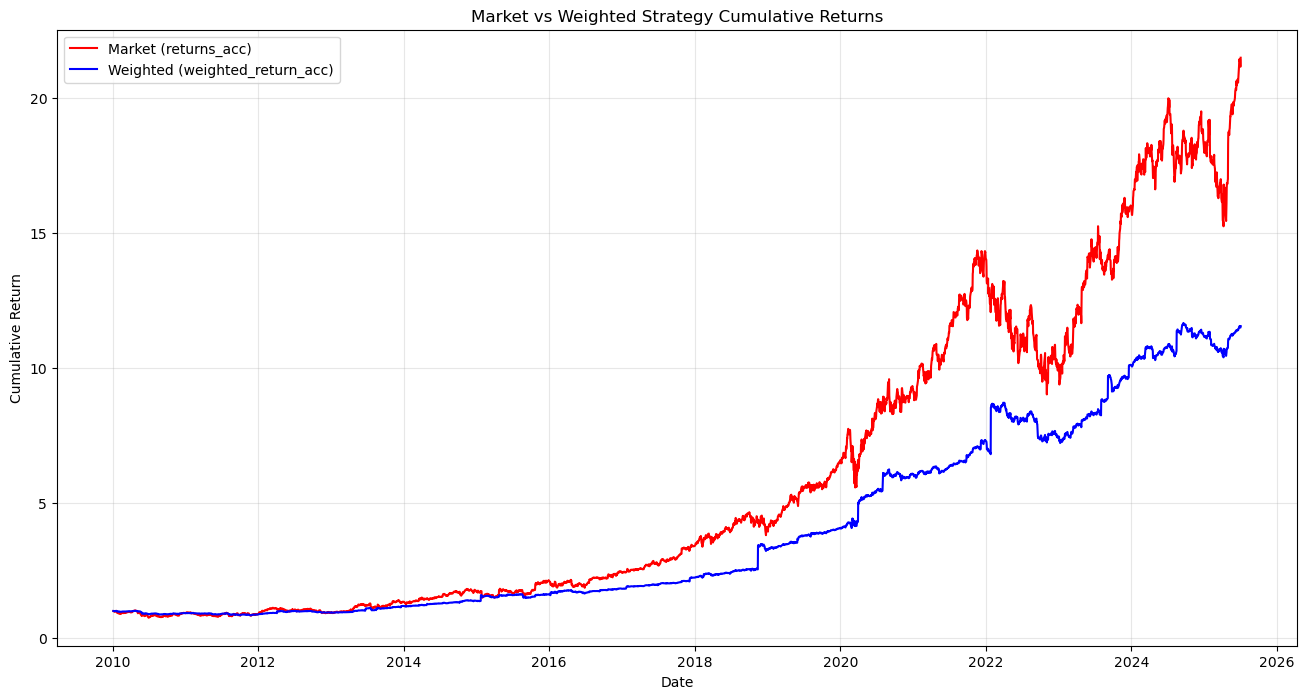

In [24]:
weights = {
    'NO_SIGNAL': 0.,      # 40% weight for no signal (cash position)
    'RSI_50_ONLY': 0.30,    # 20% weight for RSI_50 only
    'RSI_ONLY': 0.20,       # 20% weight for RSI only  
    'SMA_ONLY': 0.2        # 20% weight for SMA only
}
# Calculate weighted return for RSI_50_ONLY, RSI_ONLY, and SMA_ONLY (each 20%)
# Handle missing values by filling with 0
df['weighted_signal_return'] = (
    0.3 * df['returns'].fillna(0)
    + 0.35 * df['returns_RSI_50_ONLY'].fillna(0)
    + 0.0 * df['returns_RSI_ONLY'].fillna(0)
    + 0.35 * df['returns_SMA_ONLY'].fillna(0)
)
df['weighted_return_acc'] = (1 + df['weighted_signal_return']).cumprod()
df['weighted_signal_return']
df['weighted_return_acc']
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['returns_acc'], label='Market (returns_acc)', color='red')
plt.plot(df.index, df['weighted_return_acc'], label='Weighted (weighted_return_acc)', color='blue')
plt.title('Market vs Weighted Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Get detailed data for Period ID 62
period_id_to_analyze = 62

# First, check what signal combinations are available
print("Available signal combinations:")
for key in all_results.keys():
    print(f"  - {key}")
print()

# Check what signal period columns exist in the DataFrame
signal_period_cols = [col for col in df.columns if 'signal_period_' in str(col)]
print("Available signal period columns in DataFrame:")
for col in signal_period_cols:
    print(f"  - {col}")
print()

# Use the correct key name - it should be "RSI_RSI50_COMBO" not "RSI_RSI_50_COMBO"
signal_name = "RSI_RSI50_COMBO"

if signal_name in all_results:
    period_info = all_results[signal_name][all_results[signal_name]['period_id'] == period_id_to_analyze]
    
    if len(period_info) > 0:
        period_row = period_info.iloc[0]
        print(f"DETAILED DATA FOR PERIOD ID {period_id_to_analyze}")
        print("=" * 80)
        print(f"Period Start: {period_row['start_date'].strftime('%Y-%m-%d')}")
        print(f"Period End: {period_row['end_date'].strftime('%Y-%m-%d')}")
        print(f"Period Length: {period_row['period_length']} days")
        print(f"Buy Return: {period_row['buy_return']:.6f}")
        print(f"Sell Return: {period_row['sell_return']:.6f}")
        print()
        
        # Check if the signal period column exists
        period_col = f'signal_period_{signal_name}'
        if period_col in df.columns:
            # Get the daily data for this period from the main DataFrame
            # Filter the main DataFrame for this specific period
            period_mask = df[period_col] == period_id_to_analyze
            period_daily_data = df[period_mask].copy()
            
            if len(period_daily_data) > 0:
                print("DAILY DATA FOR THIS PERIOD:")
                print("=" * 120)
                print(f"{'Date':<12} | {'Close':<10} | {'RSI':<8} | {'RSI_Mid':<8} | {'RSI_Sig':<8} | {'RSI50_Sig':<9} | {'SMA_Sig':<8} | {'Combo':<12} | {'Sig_Diff':<9} | {'Shifted':<8}")
                print("-" * 120)
                
                for idx, row in period_daily_data.iterrows():
                    date_str = idx.strftime('%Y-%m-%d')
                    close_price = float(row[('Adj Close', 'MSFT')])
                    
                    # Robust scalar extraction handling for all column types
                    def safe_extract(val, default=0.0, value_type=float):
                        try:
                            if pd.isna(val).all() if hasattr(pd.isna(val), 'all') else pd.isna(val):
                                return value_type(default)
                            elif hasattr(val, 'iloc'):
                                return value_type(val.iloc[0])
                            else:
                                return value_type(val)
                        except:
                            return value_type(default)
                    
                    rsi_val = safe_extract(row['rsi'], 0.0, float)
                    rsi_mid_val = safe_extract(row['rsi_mid'], 0.0, float)
                    rsi_signal = safe_extract(row['rsi_signal'], 0, int)
                    rsi_50_signal = safe_extract(row['rsi_50_signal'], 0, int)
                    sma_signal = safe_extract(row['sma_signal'], 0, int)
                    signal_combo = safe_extract(row['signal_combo'], '', str)
                    
                    # Check if signal diff columns exist
                    signal_diff_col = f'signal_diff_{signal_name}'
                    signal_shifted_col = f'signal_diff_shifted_{signal_name}'
                    
                    signal_diff = safe_extract(row[signal_diff_col], 0.0, float) if signal_diff_col in df.columns else 0.0
                    signal_shifted = safe_extract(row[signal_shifted_col], 0.0, float) if signal_shifted_col in df.columns else 0.0
                    
                    print(f"{date_str:<12} | {close_price:<10.2f} | {rsi_val:<8.2f} | {rsi_mid_val:<8.2f} | {rsi_signal:<8} | {rsi_50_signal:<9} | {sma_signal:<8} | {str(signal_combo):<12} | {signal_diff:<9.0f} | {signal_shifted:<8.0f}")
                
                # Calculate price changes during the period
                start_price = float(period_daily_data[('Adj Close', 'MSFT')].iloc[0])
                end_price = float(period_daily_data[('Adj Close', 'MSFT')].iloc[-1])
                total_return = (end_price - start_price) / start_price
                
                print("\n" + "=" * 80)
                print("PERIOD SUMMARY:")
                print("=" * 80)
                print(f"Start Price: ${start_price:.2f}")
                print(f"End Price: ${end_price:.2f}")
                print(f"Total Return: {total_return:.6f} ({total_return:.2%})")
                print(f"Signal Type: {'BUY' if period_row['buy_return'] != 0 else 'SELL'}")
                print(f"Period Return: {period_row['buy_return'] if period_row['buy_return'] != 0 else period_row['sell_return']:.6f}")
                
            else:
                print(f"No daily data found for period ID {period_id_to_analyze}")
        else:
            print(f"Column '{period_col}' not found in DataFrame")
            print("Let's try to filter by date range instead...")
            
            # Alternative: filter by date range
            start_date = period_row['start_date']
            end_date = period_row['end_date']
            
            period_daily_data = df[(df.index >= start_date) & (df.index <= end_date)].copy()
            
            if len(period_daily_data) > 0:
                print(f"\nDAILY DATA FOR DATE RANGE {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}:")
                print("=" * 120)
                print(f"{'Date':<12} | {'Close':<10} | {'RSI':<8} | {'RSI_Mid':<8} | {'RSI_Sig':<8} | {'RSI50_Sig':<9} | {'SMA_Sig':<8} | {'Combo':<12}")
                print("-" * 120)
                
                for idx, row in period_daily_data.iterrows():
                    date_str = idx.strftime('%Y-%m-%d')
                    close_price = float(row[('Adj Close', 'MSFT')])
                    
                    # Robust scalar extraction handling for all column types
                    def safe_extract(val, default=0.0, value_type=float):
                        try:
                            if pd.isna(val).all() if hasattr(pd.isna(val), 'all') else pd.isna(val):
                                return value_type(default)
                            elif hasattr(val, 'iloc'):
                                return value_type(val.iloc[0])
                            else:
                                return value_type(val)
                        except:
                            return value_type(default)
                    
                    rsi_val = safe_extract(row['rsi'], 0.0, float)
                    rsi_mid_val = safe_extract(row['rsi_mid'], 0.0, float)
                    rsi_signal = safe_extract(row['rsi_signal'], 0, int)
                    rsi_50_signal = safe_extract(row['rsi_50_signal'], 0, int)
                    sma_signal = safe_extract(row['sma_signal'], 0, int)
                    signal_combo = safe_extract(row['signal_combo'], '', str)
                    
                    print(f"{date_str:<12} | {close_price:<10.2f} | {rsi_val:<8.2f} | {rsi_mid_val:<8.2f} | {rsi_signal:<8} | {rsi_50_signal:<9} | {sma_signal:<8} | {str(signal_combo):<12}")
                
                # Calculate price changes during the period
                start_price = float(period_daily_data[('Adj Close', 'MSFT')].iloc[0])
                end_price = float(period_daily_data[('Adj Close', 'MSFT')].iloc[-1])
                total_return = (end_price - start_price) / start_price
                
                print("\n" + "=" * 80)
                print("PERIOD SUMMARY:")
                print("=" * 80)
                print(f"Start Price: ${start_price:.2f}")
                print(f"End Price: ${end_price:.2f}")
                print(f"Total Return: {total_return:.6f} ({total_return:.2%})")
                print(f"Signal Type: {'BUY' if period_row['buy_return'] != 0 else 'SELL'}")
                print(f"Period Return: {period_row['buy_return'] if period_row['buy_return'] != 0 else period_row['sell_return']:.6f}")
            
    else:
        print(f"Period ID {period_id_to_analyze} not found in {signal_name} results")
else:
    print(f"Signal combination '{signal_name}' not found in results")
    print("Available combinations:", list(all_results.keys()))

Available signal combinations:
  - NO_SIGNAL
  - SMA_ONLY
  - RSI_50_ONLY
  - RSI_ONLY
  - SMA_RSI_50_COMBO
  - SMA_WITH_RSI
  - RSI_WITH_RSI_50
  - RSI_RSI50_SMA_COMBO
  - RSI_RSI50_COMBO
  - RSI_SMA_COMBO
  - RSI50_SMA_COMBO

Available signal period columns in DataFrame:
  - ('signal_period_NO_SIGNAL', '')
  - ('signal_period_SMA_ONLY', '')
  - ('signal_period_RSI_50_ONLY', '')
  - ('signal_period_RSI_ONLY', '')
  - ('signal_period_SMA_RSI_50_COMBO', '')
  - ('signal_period_SMA_WITH_RSI', '')
  - ('signal_period_RSI_WITH_RSI_50', '')
  - ('signal_period_RSI_RSI50_SMA_COMBO', '')
  - ('signal_period_RSI_RSI50_COMBO', '')
  - ('signal_period_RSI_SMA_COMBO', '')
  - ('signal_period_RSI50_SMA_COMBO', '')

DETAILED DATA FOR PERIOD ID 62
Period Start: 2015-05-27
Period End: 2015-07-21
Period Length: 56 days
Buy Return: 0.000000
Sell Return: -0.006931

DAILY DATA FOR THIS PERIOD:
Date         | Close      | RSI      | RSI_Mid  | RSI_Sig  | RSI50_Sig | SMA_Sig  | Combo        | Sig_Diff  | S

# 📊 Interactive Trading Dashboard

I've created a comprehensive Streamlit dashboard that allows you to:

## Features:
1. **Choose any ticker symbol** (MSFT, AAPL, GOOGL, etc.)
2. **Select price column** (Adj Close, Close, Open, High, Low)
3. **Customize indicator parameters**:
   - RSI period and RSI mid period
   - SMA and EMA periods
4. **Select multiple strategies** to compare:
   - RSI_ONLY
   - RSI_50_ONLY  
   - SMA_ONLY
   - RSI_RSI50_COMBO
   - And more combinations

## Dashboard Tabs:
- **📊 Summary**: Comparative performance table like we have above
- **📈 Charts**: Interactive plots showing strategy performance
- **🔍 Detailed Analysis**: Trade-by-trade breakdown
- **📋 Raw Data**: Full dataset with download capability

## How to Run the Dashboard:

### Option 1: Command Line
```bash
streamlit run trading_dashboard.py
```

### Option 2: Batch File (Windows)
```bash
run_dashboard.bat
```

The dashboard will open in your browser at `http://localhost:8501`

In [8]:
# Interactive Dashboard Functions for Notebook Use
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def create_interactive_analysis():
    """Create interactive widgets for analyzing different strategies"""
    
    # Strategy selection widget
    strategy_dropdown = widgets.SelectMultiple(
        options=list(all_results.keys()),
        value=['RSI_ONLY', 'RSI_50_ONLY', 'SMA_ONLY'],
        description='Strategies:',
        style={'description_width': 'initial'},
        layout={'width': '400px', 'height': '150px'}
    )
    
    # Period ID slider for detailed analysis
    period_slider = widgets.IntSlider(
        value=62,
        min=1,
        max=100,
        description='Period ID:',
        style={'description_width': 'initial'}
    )
    
    # Ticker input (for future use)
    ticker_input = widgets.Text(
        value='MSFT',
        description='Ticker:',
        style={'description_width': 'initial'}
    )
    
    # Analysis button
    analyze_button = widgets.Button(
        description='📊 Analyze Selected Strategies',
        button_style='success',
        layout={'width': '300px'}
    )
    
    # Output area
    output = widgets.Output()
    
    def on_analyze_click(b):
        with output:
            clear_output(wait=True)
            
            selected_strategies = list(strategy_dropdown.value)
            period_id = period_slider.value
            
            print(f"📈 ANALYSIS FOR SELECTED STRATEGIES")
            print(f"{'='*80}")
            print(f"Period ID: {period_id}")
            print(f"Selected Strategies: {', '.join(selected_strategies)}")
            print(f"{'='*80}")
            
            # Create comparison table for selected strategies
            comparison_data = []
            
            for name in selected_strategies:
                if name in all_results:
                    result_df = all_results[name]
                    
                    if len(result_df) > 0:
                        num_trades = (result_df['period_length'] > 1).sum()
                        num_positive = (result_df['buy_return'] > 0).sum()
                        win_rate = num_positive / num_trades if num_trades > 0 else 0
                        avg_return = result_df[result_df['buy_return'] > 0]['buy_return'].mean() if num_positive > 0 else 0
                        total_return = (1 + result_df['buy_return']).prod() - 1
                        
                        multi_day_trades = result_df[result_df['period_length'] > 1]
                        avg_length = multi_day_trades['period_length'].mean() if len(multi_day_trades) > 0 else 0
                        
                        comparison_data.append({
                            'Strategy': name,
                            'Total Trades': num_trades,
                            'Win Rate': f"{win_rate:.2%}",
                            'Avg Return': f"{avg_return:.2%}" if num_positive > 0 else "N/A",
                            'Total Return': f"{total_return:.2%}",
                            'Avg Length': f"{avg_length:.1f}" if avg_length > 0 else "N/A"
                        })
            
            # Display comparison table
            if comparison_data:
                comparison_df = pd.DataFrame(comparison_data)
                print("\\nCOMPARATIVE SUMMARY:")
                print("-" * 80)
                for _, row in comparison_df.iterrows():
                    print(f"{row['Strategy']:<20} | {row['Total Trades']:<12} | {row['Win Rate']:<10} | {row['Avg Return']:<12} | {row['Total Return']:<12} | {row['Avg Length']:<10}")
            
            # Show period details for first selected strategy
            if selected_strategies and selected_strategies[0] in all_results:
                strategy_name = selected_strategies[0]
                result_df = all_results[strategy_name]
                
                period_info = result_df[result_df['period_id'] == period_id]
                
                if len(period_info) > 0:
                    period_row = period_info.iloc[0]
                    print(f"\\n\\nDETAILED DATA FOR {strategy_name} - PERIOD ID {period_id}")
                    print("=" * 80)
                    print(f"Period Start: {period_row['start_date'].strftime('%Y-%m-%d')}")
                    print(f"Period End: {period_row['end_date'].strftime('%Y-%m-%d')}")
                    print(f"Period Length: {period_row['period_length']} days")
                    print(f"Buy Return: {period_row['buy_return']:.6f}")
                    print(f"Sell Return: {period_row['sell_return']:.6f}")
                else:
                    print(f"\\nPeriod ID {period_id} not found in {strategy_name} results")
            
            # Create a simple plot
            plt.figure(figsize=(14, 8))
            
            # Plot market returns
            plt.plot(df.index, df['returns_acc'], label='Market (Buy & Hold)', color='red', linewidth=2)
            
            # Plot selected strategy returns
            colors = ['blue', 'green', 'orange', 'purple', 'brown']
            for i, strategy in enumerate(selected_strategies):
                if f'ret_acc_{strategy}' in df.columns:
                    plt.plot(df.index, df[f'ret_acc_{strategy}'], 
                            label=strategy, color=colors[i % len(colors)], linewidth=1.5)
            
            plt.title(f'Cumulative Returns Comparison - {ticker_input.value}')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    analyze_button.on_click(on_analyze_click)
    
    # Layout
    controls = widgets.VBox([
        widgets.HTML("<h3>📊 Interactive Strategy Analysis</h3>"),
        widgets.HBox([ticker_input, period_slider]),
        strategy_dropdown,
        analyze_button
    ])
    
    dashboard = widgets.VBox([controls, output])
    
    return dashboard

# Create and display the interactive dashboard
try:
    dashboard = create_interactive_analysis()
    display(dashboard)
    print("✅ Interactive dashboard created! Use the widgets above to analyze different strategies.")
except Exception as e:
    print(f"⚠️ Error creating interactive dashboard: {e}")
    print("💡 You may need to install ipywidgets: pip install ipywidgets")
    print("📝 Alternative: Use the Streamlit dashboard by running: streamlit run trading_dashboard.py")

✅ Interactive dashboard created! Use the widgets above to analyze different strategies.
